# NSGA2 Generator
This notebook demonstrates the use of the generator `NSGA2Generator` which implements the NSGA-II algorithm from [1]. We show how to set up the optimizer object, use it to solve a test problem, and show off some of the generator's output features. Running this notebook will generate files in a temporary directory on your computer. These files will be cleaned up at the end.

In [ ]:
import json
import logging
import matplotlib.pyplot as plt
import os
import pandas as pd
import shutil
import tempfile

from xopt.generators.ga.nsga2 import NSGA2Generator, PolynomialMutation, SimulatedBinaryCrossover
from xopt.resources.test_functions.zdt import construct_zdt
from xopt import Xopt, Evaluator

In [2]:
# The NSGA2Generator object emits logger messages
# Configure the logging module to output them to console
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',  # Format for log messages
    datefmt='%Y-%m-%d %H:%M:%S'  # Date/time format
)

In [3]:
# Get the problem ZDT2 and create an Xopt evaluator
prob_vocs, prob_fun, _ = construct_zdt(30, 3)
ev = Evaluator(function=prob_fun)

### Generator Setup and Use
First we create the `NSGA2Generator` object, demonstrate some of its settings, and then use it to solve the ZDT3 test problem.

In [4]:
# Create the NSGA2 generator with default settings
generator = NSGA2Generator(
    vocs=prob_vocs,  # Must provide the problem's details
)

# Let's demonstrate controlling the generator's hyperparameters and settings
generator = NSGA2Generator(
    vocs=prob_vocs,  # Must provide the problem's details
    population_size=50,  # How many individuals in a population
    mutation_operator=PolynomialMutation(pm=1/30, eta_m=20),  # Can manually specify mutation operator and hyperparameters
    crossover_operator=SimulatedBinaryCrossover(delta_1=0.5, delta_2=0.5, eta_c=20),  # Similarly can specify crossover manually
    deduplicate_output=True,  # Performs deduplication of candidate individuals. Ensure unique outputs from generator.
)

2025-03-02 19:01:40 - xopt.generator - INFO - Initialized generator nsga2
2025-03-02 19:01:40 - xopt.generator - INFO - Initialized generator nsga2


In [5]:
# Run the optimizer for a few generations. Notice log output printed below this cell
ev.max_workers = generator.population_size
X = Xopt(generator=generator, evaluator=ev, vocs=prob_vocs)

for _ in range(3):
    X.step()

2025-03-02 19:01:40 - xopt.base - INFO - Running Xopt step
2025-03-02 19:01:40 - xopt.generators.deduplicated - INFO - generated 50 candidates in 2.83ms (removed 0 duplicate individuals)
2025-03-02 19:01:40 - xopt.generators.ga.nsga2 - INFO - adding 50 new evaluated individuals to generator
2025-03-02 19:01:40 - xopt.generators.ga.nsga2 - INFO - completed generation 1 in 0.019s (n_feasible=0, n_err=0, children_performance=0.000s (0.000s), add_data_round=0, fevals=50, n_candidates=50)
2025-03-02 19:01:40 - xopt.base - INFO - Running Xopt step
2025-03-02 19:01:40 - xopt.generators.deduplicated - INFO - generated 50 candidates in 10.44ms (removed 0 duplicate individuals)
2025-03-02 19:01:40 - xopt.generators.ga.nsga2 - INFO - adding 50 new evaluated individuals to generator
2025-03-02 19:01:40 - xopt.generators.ga.nsga2 - INFO - completed generation 2 in 0.022s (n_feasible=0, n_err=0, children_performance=0.000s (0.000s), add_data_round=0, fevals=100, n_candidates=100)
2025-03-02 19:01:40

### Exploring Optimizer Output
We now take a look at the metadata associated with the optimizer run as well as its output.

In [6]:
%%time
# Run for longer with log output turned off
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

for _ in range(47):
    X.step()

CPU times: total: 812 ms
Wall time: 935 ms


In [7]:
# Inspect generator properties
print(f"Saw {generator.fevals} function evaluations")  # Number of function evaluations returned to generator
print(f"Completed {generator.n_generations} generations")  # Number of generations finished
print(f"Generated {generator.n_candidates} candidate solutions")  # Number of individuals generated

Saw 2500 function evaluations
Completed 50 generations
Generated 2500 candidate solutions


In [8]:
# All evaluations are stored in the following Dataframe. Speific to this generator, a `xopt_parent_generation` and 
# `xopt_candidate_idx` columns which indicate from which generation the indvidual's parents belong to as well as providing a 
# unique index for indviduals.
# 
# NOTE: The data DataFrame is not stored when serializing the generator. It must be saved on its own for later use.
generator.data.head()

,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x7,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error
0,0.009655,0.723504,0.510601,0.606089,0.041130,0.641634,0.418935,0.232881,0.115789,0.597597,...,0.088527,0.626009,0.842861,0,49,0.009655,5.464468,5.701984,0.000037,False
1,0.030879,0.105435,0.893054,0.841672,0.986468,0.674358,0.948891,0.682192,0.162853,0.609564,...,0.317319,0.699722,0.177070,0,19,0.030879,5.370687,5.820091,0.000012,False
2,0.039205,0.339948,0.563730,0.376435,0.022820,0.259893,0.416951,0.563694,0.047288,0.127156,...,0.653925,0.249955,0.995889,0,38,0.039205,4.527716,5.007782,0.000009,False
3,0.083683,0.585037,0.136998,0.959501,0.921864,0.598143,0.339078,0.750055,0.872647,0.128444,...,0.046880,0.706720,0.925208,0,8,0.083683,4.914921,5.643158,0.000008,False
4,0.095669,0.675927,0.715267,0.679421,0.418973,0.366127,0.963364,0.571507,0.553803,0.305484,...,0.785290,0.675562,0.854649,0,6,0.095669,5.286252,6.060688,0.000008,False


In [9]:
# Each population the optimizer has seen is stored by the unique indices of each individual.
print(generator.history_idx[-1][:16])  # Show the first few indices of last generation

# If you have the data DataFrame you can extract all variables, objectives, constraints for each population
# Get a DataFrame of all information for the first population with every row being an individual
generator.data[generator.data["xopt_candidate_idx"].isin(generator.history_idx[0])].head()

[2496, 2422, 2480, 2447, 2373, 2426, 2482, 2366, 2427, 2465, 2420, 2461, 2169, 2478, 2319, 2095]


,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x7,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error
0,0.009655,0.723504,0.510601,0.606089,0.041130,0.641634,0.418935,0.232881,0.115789,0.597597,...,0.088527,0.626009,0.842861,0,49,0.009655,5.464468,5.701984,0.000037,False
1,0.030879,0.105435,0.893054,0.841672,0.986468,0.674358,0.948891,0.682192,0.162853,0.609564,...,0.317319,0.699722,0.177070,0,19,0.030879,5.370687,5.820091,0.000012,False
2,0.039205,0.339948,0.563730,0.376435,0.022820,0.259893,0.416951,0.563694,0.047288,0.127156,...,0.653925,0.249955,0.995889,0,38,0.039205,4.527716,5.007782,0.000009,False
3,0.083683,0.585037,0.136998,0.959501,0.921864,0.598143,0.339078,0.750055,0.872647,0.128444,...,0.046880,0.706720,0.925208,0,8,0.083683,4.914921,5.643158,0.000008,False
4,0.095669,0.675927,0.715267,0.679421,0.418973,0.366127,0.963364,0.571507,0.553803,0.305484,...,0.785290,0.675562,0.854649,0,6,0.095669,5.286252,6.060688,0.000008,False


Text(0.5, 1.0, 'ZDT3, Generation 50')

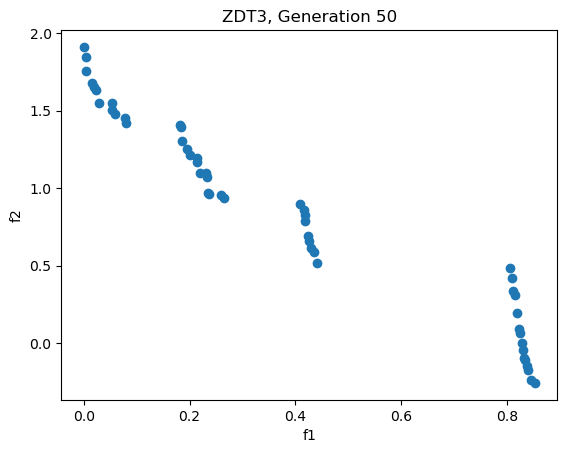

In [10]:
# Using the population records we can plot the final generation's objective functions
final_pop = generator.data[generator.data["xopt_candidate_idx"].isin(generator.history_idx[-1])]
plt.scatter(final_pop["f1"], final_pop["f2"])
plt.xlabel("f1")
plt.ylabel("f2")
plt.title(f"ZDT3, Generation {generator.n_generations}")

# File Output from Generator
In this section, we will take a look at the files which can be automatically written by the optimizer. We will create a temporary directory and clean it up at the end of this notebook.

The output files are the following.
 - `data.csv`: All data evaluated during the optimization
 - `vocs.txt`: The VOCS object so that the objectives, constraints, decision variables are retained alongside the data
 - `populations.csv`: Each population is written here with a column `xopt_generation` to distinguish which generation the row belongs to
 - `checkpoints`: This generator periodically saves its full state to timestamped files in this directory

In [11]:
# Setup our output directory
output_dir = tempfile.mkdtemp()
print(f"Will write data to \"{output_dir}\"")

Will write data to "C:\Users\chris\AppData\Local\Temp\tmpucliivtb"


In [12]:
# Set up a generator configured to output data
generator = NSGA2Generator(
    vocs=prob_vocs,
    output_dir=output_dir,  # Where will we write data
    checkpoint_freq=8,  # How often (in terms of generations) should we save the optimizer state?
)

# Run it for a couple of generations
ev.max_workers = generator.population_size
X = Xopt(generator=generator, evaluator=ev, vocs=prob_vocs)
for _ in range(32):
    X.step()

In [13]:
# Check out the generated files
print(f"\"{output_dir}\": {os.listdir(output_dir)}")
checkpoint_dir = os.path.join(output_dir, "checkpoints")
print(f"\"checkpoints\": {os.listdir(checkpoint_dir)}")

"C:\Users\chris\AppData\Local\Temp\tmpucliivtb": ['checkpoints', 'data.csv', 'populations.csv', 'vocs.txt']
"checkpoints": ['20250302_190141_1.txt', '20250302_190142_1.txt', '20250302_190142_2.txt', '20250302_190142_3.txt']


In [14]:
# In the event data was already written to `output_dir` the generator will choose a new path with a numeric suffix
# to avoid overwriting anything.
X = Xopt(generator=NSGA2Generator(vocs=prob_vocs, output_dir=output_dir), evaluator=ev, vocs=prob_vocs)
for _ in range(32):
    X.step()

# Compare the requested path and where the data ended up
print(f"Requested path: \"{output_dir}\"")
print(f"Path used:      \"{X.generator.output_dir}\"")

Requested path: "C:\Users\chris\AppData\Local\Temp\tmpucliivtb"
Path used:      "C:\Users\chris\AppData\Local\Temp\tmpucliivtb_2"


In [15]:
# Load all data back in
df = pd.read_csv(os.path.join(generator.output_dir, "data.csv"))
df.head()

,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x7,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error
0,0.028343,0.961382,0.360412,0.035008,0.187363,0.398648,0.862417,0.995013,0.113727,0.538076,...,0.259310,0.254639,0.489805,0,48,0.028343,5.201428,5.622667,0.000030,False
1,0.048097,0.600759,0.048774,0.736421,0.019531,0.075107,0.256366,0.321966,0.995007,0.057375,...,0.157952,0.434538,0.004108,0,34,0.048097,3.975436,4.488059,0.000010,False
2,0.109106,0.710277,0.936047,0.980964,0.688982,0.993878,0.182528,0.751694,0.469937,0.237268,...,0.926371,0.772502,0.950987,0,8,0.109106,5.367148,6.155900,0.000008,False
3,0.143250,0.028147,0.284909,0.524071,0.490972,0.613505,0.905744,0.441154,0.364948,0.429968,...,0.801864,0.898205,0.180182,0,42,0.143250,4.515525,5.242041,0.000008,False
4,0.144426,0.150729,0.559514,0.217257,0.748062,0.590286,0.693985,0.032077,0.893225,0.044885,...,0.568332,0.856421,0.407714,0,10,0.144426,4.636841,5.375758,0.000008,False


In [16]:
# Load the populations and get just the last population
df = pd.read_csv(os.path.join(generator.output_dir, "populations.csv"))
last_pop = df[df["xopt_generation"] == df["xopt_generation"].max()]
last_pop.head()

,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error,xopt_generation
1550,0.000025,0.028798,0.044830,0.097424,0.005687,0.279121,0.014729,0.197079,0.009939,0.001525,...,0.310929,0.071410,30,1506,0.000025,1.804481,1.811150,0.000024,False,32
1551,0.653067,0.031038,0.035679,0.074338,0.031493,0.104509,0.041089,0.207896,0.078048,0.058759,...,0.318371,0.059268,30,1500,0.653067,0.070471,1.806756,0.000008,False,32
1552,0.436928,0.030187,0.036309,0.007488,0.031012,0.111709,0.061951,0.214503,0.077763,0.002256,...,0.309991,0.061366,30,1518,0.436928,0.513990,1.801885,0.000008,False,32
1553,0.618334,0.031167,0.037719,0.126287,0.039472,0.265157,0.061467,0.183101,0.079983,0.058996,...,0.221409,0.064188,30,1535,0.618334,0.483494,1.905835,0.000007,False,32
1554,0.264297,0.054107,0.020719,0.057886,0.040137,0.113555,0.061830,0.094260,0.078048,0.057730,...,0.304849,0.059123,31,1559,0.264297,0.903740,1.838986,0.000008,False,32


In [17]:
# Reload the optimizer from its last checkpoint
# NOTE: the vocs object is not retained with the checkpoint and should be added as in the following code
last_checkpoint = os.path.join(checkpoint_dir, os.listdir(checkpoint_dir)[-1])
with open(last_checkpoint) as f:
    restored_generator = NSGA2Generator.from_dict({"vocs": prob_vocs, **json.load(f)})
print(f"From file: {restored_generator}")

# Demonstrate using the generator after loading (starting optimization from its last saved point)
X = Xopt(generator=restored_generator, evaluator=ev, vocs=prob_vocs)
for _ in range(32):
    X.step()
print(f"Further optimization: {restored_generator}")

From file: NSGA2Generator(pop_size=50, crossover=SimulatedBinaryCrossover, mutation=PolynomialMutation, deduplicated=True, completed_gens=32, fevals=1600)
Further optimization: NSGA2Generator(pop_size=50, crossover=SimulatedBinaryCrossover, mutation=PolynomialMutation, deduplicated=True, completed_gens=64, fevals=3200)


In [18]:
# Clean up the output directory
shutil.rmtree(output_dir)